In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import statsmodels.api as sm

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet

from pmdarima.arima import auto_arima

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

<IPython.core.display.Javascript object>

In [40]:
data = pd.read_csv("data/AEP_hourly.csv")
data.columns = ["datetime", "mw"]
data.head()

datetime       mw
0  2004-12-31 01:00:00  13478.0
1  2004-12-31 02:00:00  12865.0
2  2004-12-31 03:00:00  12577.0
3  2004-12-31 04:00:00  12517.0
4  2004-12-31 05:00:00  12670.0

<IPython.core.display.Javascript object>

In [41]:
data["datetime"] = pd.to_datetime(data["datetime"])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   datetime  121273 non-null  datetime64[ns]
 1   mw        121273 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 MB


<IPython.core.display.Javascript object>

In [42]:
data["date"] = data["datetime"].dt.date
data.drop(columns=["datetime"], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   mw      121273 non-null  float64
 1   date    121273 non-null  object 
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


<IPython.core.display.Javascript object>

In [45]:
data = data.groupby("date", as_index=False).agg({"mw": "mean"})
data["date"] = pd.to_datetime(data["date"])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5055 entries, 0 to 5054
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5055 non-null   datetime64[ns]
 1   mw      5055 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 118.5 KB


<IPython.core.display.Javascript object>

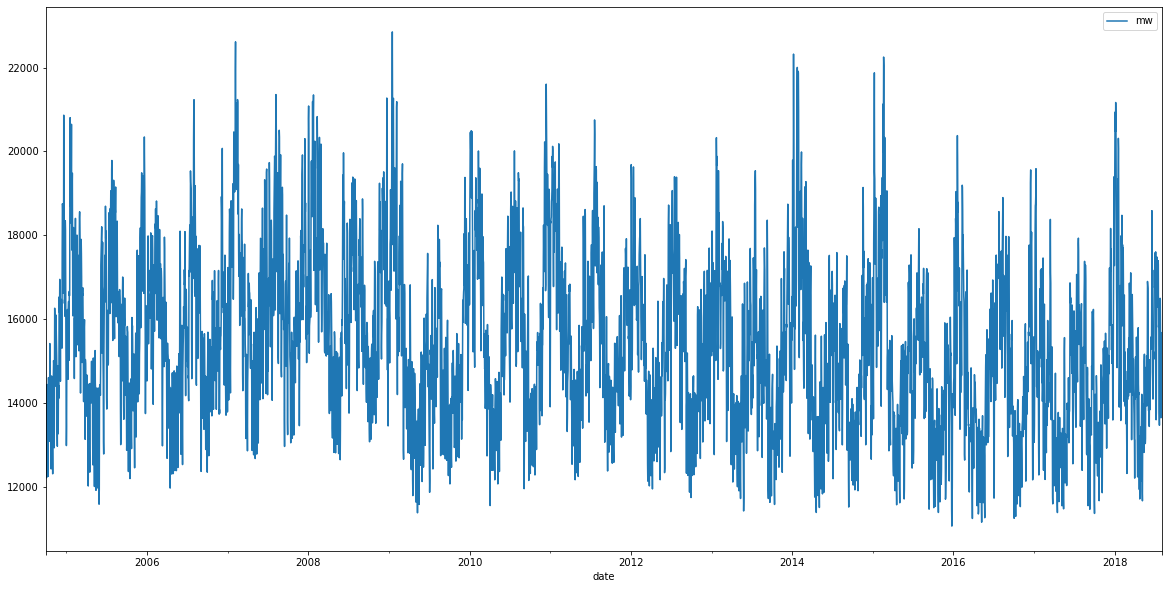

<IPython.core.display.Javascript object>

In [46]:
data.set_index("date").plot(figsize=(20, 10))

In [47]:
series = data.set_index("date")
decomposition = sm.tsa.seasonal_decompose(series, model="additive", period=24)


trend = decomposition.trend
seasonality = decomposition.seasonal
resid = decomposition.resid

merged = data.merge(trend, on="date")
merged = merged.merge(seasonality, on="date")
merged = merged.merge(resid, on="date")
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5055 entries, 0 to 5054
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      5055 non-null   datetime64[ns]
 1   mw        5055 non-null   float64       
 2   trend     5031 non-null   float64       
 3   seasonal  5055 non-null   float64       
 4   resid     5031 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 237.0 KB


<IPython.core.display.Javascript object>

In [49]:
ids = ["date"]
values = set(merged.columns) - set(ids)
# values = merged.columns

melted = pd.melt(merged, id_vars=ids, value_vars=values)
melted

date  variable         value
0     2004-10-01        mw  14284.521739
1     2004-10-02        mw  12999.875000
2     2004-10-03        mw  12227.083333
3     2004-10-04        mw  14309.041667
4     2004-10-05        mw  14439.708333
...          ...       ...           ...
20215 2018-07-30  seasonal    -72.986304
20216 2018-07-31  seasonal   -120.297715
20217 2018-08-01  seasonal     -2.459750
20218 2018-08-02  seasonal     -3.241243
20219 2018-08-03  seasonal    -24.720252

[20220 rows x 3 columns]

<IPython.core.display.Javascript object>

In [51]:
px.line(melted, x="date", y="value", color="variable")

<IPython.core.display.Javascript object>

With a period of 24 hours, there is no seasonality, but the trend is variable. I'll check for stationarity, and do differencing if it is not.

In [52]:
adf_test = sm.tsa.stattools.adfuller(data["mw"])

results = pd.Series(
    adf_test[0:4],
    index=["ADF Test Statistic", "P-Value", "# Lags Used", "# Observations Used"],
)

for key, value in adf_test[4].items():
    results["Critical Value (%s)" % key] = value

print("Augmented Dickey-Fuller Test Results:\n")
print(results)

Augmented Dickey-Fuller Test Results:

ADF Test Statistic     -7.487516e+00
P-Value                 4.597183e-11
# Lags Used             3.000000e+01
# Observations Used     5.024000e+03
Critical Value (1%)    -3.431652e+00
Critical Value (5%)    -2.862115e+00
Critical Value (10%)   -2.567076e+00
dtype: float64


<IPython.core.display.Javascript object>

With a very small p-value, we reject the null and accept the alternative that the data is stationary. 

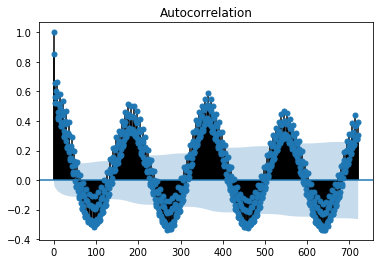

<IPython.core.display.Javascript object>

In [53]:
from statsmodels.graphics.tsaplots import plot_acf

fig = plot_acf(data["mw"], lags=24 * 30)
# fig.figure(10, 20)
# fig.show()

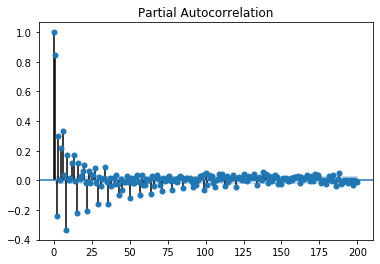

<IPython.core.display.Javascript object>

In [55]:
from statsmodels.graphics.tsaplots import plot_pacf

fig = plot_pacf(data["mw"], lags=200)

From the partial autocorrelation plot, it appears there is recurring, significant auto correlation, peaking at about every 100 days, with no diminishment. From the partial autocorrelation plot, it appears that 50-100 lags is where the autocorrelation drops off.

### ARIMA Modeling

In [68]:
data = data.set_index("date")
# data.head()

KeyError: "None of ['date'] are in the columns"

<IPython.core.display.Javascript object>

In [76]:
# split the data to evaluate predictions
n = data.shape[0]
train_size = int(0.8 * n)
test_size = int(0.2 * n)

train_data = data[:train_size]
test_data = data[-test_size:]

<IPython.core.display.Javascript object>

In [82]:
# checking the tail of the train and head of the test to make sure this is no overlap
train_data.tail()

mw
date                    
2015-10-23  13017.750000
2015-10-24  11841.041667
2015-10-25  11402.541667
2015-10-26  13260.958333
2015-10-27  13877.291667

<IPython.core.display.Javascript object>

In [81]:
test_data.head()

mw
date                    
2015-10-28  13596.416667
2015-10-29  13321.541667
2015-10-30  13729.291667
2015-10-31  12783.916667
2015-11-01  11654.040000

<IPython.core.display.Javascript object>

In [84]:
model = SARIMAX(train_data["mw"], order=(2, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
sarima_forecasts = model.forecast(test_size, index=test_data.index)

C:\Users\dgump\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\dgump\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\dgump\miniconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<IPython.core.display.Javascript object>

In [90]:
r2_score(test_data['mw'], sarima_forecasts)


-0.5806544274009449

<IPython.core.display.Javascript object>

My naive SARIMAX model is laughable bad, probably because I am also laughably naive. I'll use auto-ARIMA and see if I can do better.

In [92]:
auto_model = auto_arima(
    train_data,
    start_p=0,
    d=1,
    start_q=0,
    max_p=5,
    max_d=5,
    max_q=5,
    start_P=0,
    D=1,
    start_Q=0,
    max_P=5,
    max_D=5,
    max_Q=5,
    m=365,
    seasonal=True,
    stepwise=True,
    n_jobs=-1,
)

C:\Users\dgump\miniconda3\lib\site-packages\pmdarima\arima\_validation.py:75: UserWarning:

stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.



MemoryError: Unable to allocate 4.06 GiB for an array with shape (367, 367, 4044) and data type float64

<IPython.core.display.Javascript object>